# GOOGLENET : train/test/valid set로 나눈 뒤 학습 

In [1]:
from tensorflow.keras.layers import Concatenate, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import tensorflow

In [2]:
os.getcwd()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def inception_module(x, base_channels=32):
    a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
    b_1 = Conv2D(base_channels*4, 1, 1, activation='relu')(x)
    b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)
    c_1 = Conv2D(base_channels, 1, 1, activation='relu')(x)
    c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)
    d_1 = MaxPooling2D(3, 1, padding='same')(x)
    d_2 = Conv2D(base_channels, 1, 1, activation='relu')(d_1)
    return Concatenate(axis=-1)([a, b_2, c_2, d_2])

In [4]:
def googleNet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, base_channels=32)
    x = inception_module(x, base_channels=32)
    x = inception_module(x, base_channels=32)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
data_dir = 'archive/train'
data_dir_test = 'archive/test'

In [6]:
img_width, img_height = 180,180
num_classes = len(os.listdir(data_dir)) # 상위 디렉토리 내에 있는 감정 폴더의 갯수로 

In [7]:
# 전처리
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,

    # 이미지 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

batch_size = 32

In [8]:
# 훈련셋, 검증셋, 테스트셋으로 데이터 나누고 전처리 
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [9]:
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
# test set
test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset=None # 테스트 셋 따로 지정하지 않고 전체 다 돌림 
)

Found 7178 images belonging to 7 classes.


In [12]:
# 모델 생성, 컴파일 
model = googleNet_model((img_width, img_height, 3), num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# 모델 학습
googlenet = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=100
)

loss, accuracy = model.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/100
717/717 [==============================] - 187s 248ms/step - loss: 1.8222 - accuracy: 0.2476 - val_loss: 1.7716 - val_accuracy: 0.2659
Epoch 2/100
717/717 [==============================] - 172s 239ms/step - loss: 1.7804 - accuracy: 0.2614 - val_loss: 1.7418 - val_accuracy: 0.2959
Epoch 3/100
717/717 [==============================] - 169s 235ms/step - loss: 1.7508 - accuracy: 0.2848 - val_loss: 1.7352 - val_accuracy: 0.3062
Epoch 4/100
717/717 [==============================] - 171s 239ms/step - loss: 1.6954 - accuracy: 0.3229 - val_loss: 1.6559 - val_accuracy: 0.3375
Epoch 5/100
717/717 [==============================] - 171s 238ms/step - loss: 1.6249 - accuracy: 0.3589 - val_loss: 1.5718 - val_accuracy: 0.3914
Epoch 6/100
717/717 [==============================] - 172s 239ms/step - loss: 1.5667 - accuracy: 0.3890 - val_loss: 1.5245 - val_accuracy: 0.4160
Epoch 7/100
717/717 [==============================] - 189s 263ms/step - loss: 1.5145 - accuracy: 0.4189 - val_loss: 1

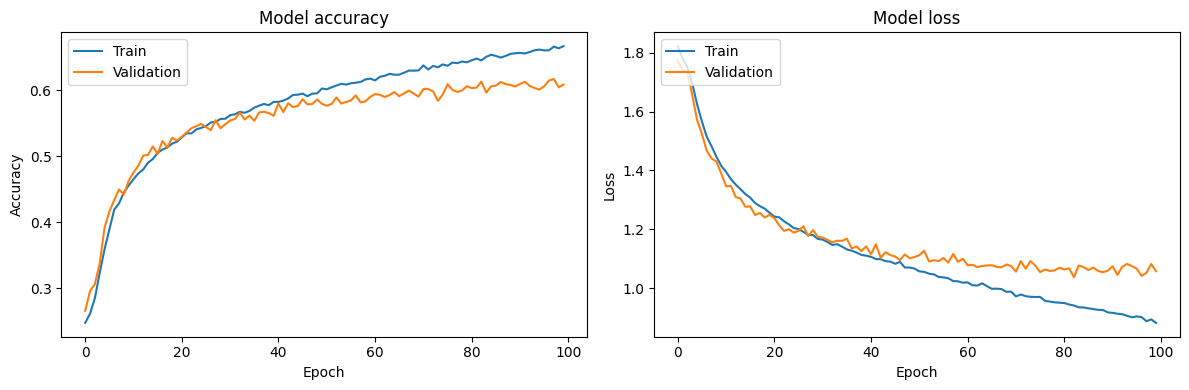

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(googlenet)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def evaluate_and_display_emotion(model, base_dir, img_width, img_height):
    class_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
    num_classes = len(class_labels)

    y_true = []
    y_pred = []

    sub_dirs = os.listdir(base_dir)
    for sub_dir in sub_dirs:
        folder_path = os.path.join(base_dir, sub_dir)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            
            # 이미지 불러오기 및 전처리
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # 예측
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            
            # 예측 결과 출력
            print(f"Image: {img_file} - True Emotion: {sub_dir} - Predicted Emotion: {class_labels[predicted_class]}")
            
            # 실제 레이블과 예측 레이블 추가
            y_true.append(class_labels.index(sub_dir))
            y_pred.append(predicted_class)

    # 정확도 계산
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    
    # 손실 계산
    loss_fn = CategoricalCrossentropy()
    loss = loss_fn(to_categorical(y_true, num_classes=num_classes), to_categorical(y_pred, num_classes=num_classes))

    print(f"\nPrediction Accuracy: {accuracy * 100:.2f}%")
    print(f"Prediction Loss: {loss:.4f}")

# 결과 출력
base_dir = "C:/workspaces/workspace_ds/archive/test"
evaluate_and_display_emotion(model, base_dir, img_width, img_height)

1/1 [==============================] - 0s 16ms/step
Image: PrivateTest_10131363.jpg - True Emotion: angry - Predicted Emotion: angry
1/1 [==============================] - 0s 15ms/step
Image: PrivateTest_10304478.jpg - True Emotion: angry - Predicted Emotion: angry
1/1 [==============================] - 0s 15ms/step
Image: PrivateTest_1054527.jpg - True Emotion: angry - Predicted Emotion: sad
1/1 [==============================] - 0s 15ms/step
Image: PrivateTest_10590091.jpg - True Emotion: angry - Predicted Emotion: sad
1/1 [==============================] - 0s 16ms/step
Image: PrivateTest_1109992.jpg - True Emotion: angry - Predicted Emotion: angry
1/1 [==============================] - 0s 14ms/step
Image: PrivateTest_11296953.jpg - True Emotion: angry - Predicted Emotion: fear
1/1 [==============================] - 0s 14ms/step
Image: PrivateTest_12000629.jpg - True Emotion: angry - Predicted Emotion: sad
1/1 [==============================] - 0s 14ms/step
Image: PrivateTest_1200838